In [1]:
import re
import warnings
import shapely
import pandas as pd
import geopandas as gpd
import yaml

from typing import Union, Tuple
from pathlib import Path
from multiprocessing import Pool, cpu_count


class GSONTile:
    def __init__(
        self,
        fname: Union[Path, str],
        xmin: int = None,
        ymin: int = None,
        tile_size: int = (1000, 1000),
    ) -> None:
        """Class abstaraction for one tile of geojson annotations.

        Parameters
        ----------
            fname : Path or str
                Name of the gson file.
            xmin : int, default=None
                The min-x coordinate of the tile.
            ymin : int, default=None
                The min-y coordinate of the tile.
            tile_size : Tuple[int, int], default=(1000, 1000))
                Size of the input tile.
        """
        assert Path(fname).exists(), f"File {fname} not found."
        assert Path(fname).suffix in (
            ".json",
            ".geojson",
        ), f"Input File {fname} has wrong format. Expected '.json'."

        self.fname = Path(fname)

        if None in (xmin, ymin):
            xmin, ymin = self._get_xy_coords(self.fname)

        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmin + tile_size[0]
        self.ymax = ymin + tile_size[1]

    def __len__(self):
        df = pd.read_json(self.fname)
        length = len(df)

        # empty mem
        del df

        return length

    def __set_value(
        self, anns1: gpd.GeoDataFrame, anns2: gpd.GeoDataFrame
    ) -> gpd.GeoDataFrame:
        """Catch annoying future warning to not flood stdout."""
        with warnings.catch_warnings():
            # Setting values in-place is fine, ignore the warning in Pandas >= 1.5.0
            # This can be removed, if Pandas 1.5.0 does not need to be supported any
            # longer. See also: https://stackoverflow.com/q/74057367/859591
            warnings.filterwarnings(
                "ignore",
                category=FutureWarning,
                message=(
                    ".*will attempt to set the values inplace instead of always setting a new array. "
                    "To retain the old behavior, use either.*"
                ),
            )
            anns1.loc[:, "geometry"] = anns2

        return anns1

    def _get_xy_coords(self, fname: str) -> Tuple[int, int]:
        """fname needs to contain x & y-coordinates in "x-[coord1]_y-[coord2]"-format"""
        if isinstance(fname, Path):
            fname = fname.as_posix()

        assert re.findall(
            r"(x-\d+_y-\d+)", fname
        ), "fname not in 'x-[coord1]_y-[coord2]'-format"
        xy_str = re.findall(r"(x-\d+_y-\d+)", fname)
        x, y = (int(c) for c in re.findall(r"\d+", xy_str[0]))

        return x, y

    @property
    def gdf(self) -> gpd.GeoDataFrame:
        """Read a geojson/json file and convert it to geopandas df

        NOTE: Adds bounding box-coords for the polygons.
        """
        # try:
        df = pd.read_json(self.fname)

        if df.empty:
            warnings.warn(
                f"No annotations detected in {self.fname.name}. Returning None.",
                RuntimeWarning,
            )

            return None

        df["geometry"] = df["geometry"].apply(shapely.geometry.shape)
        gdf = gpd.GeoDataFrame(df).set_geometry("geometry")

        # drop invalid geometries if there are any after buffer
        #gdf.geometry = gdf.geometry.buffer(0)
        #gdf = gdf[gdf.is_valid]

        # drop empty geometries
        #gdf = gdf[~gdf.is_empty]

        # drop geometries that are not polygons
        #gdf = gdf[gdf.geom_type == "Polygon"]

        try:
            # add bounding box coords of the polygons to the gdfs
            # and correct for the max coords
            gdf["xmin"] = gdf.bounds["minx"].astype(int)
            gdf["ymin"] = gdf.bounds["miny"].astype(int)
            gdf["ymax"] = gdf.bounds["maxy"].astype(int) + 1
            gdf["xmax"] = gdf.bounds["maxx"].astype(int) + 1
        except Exception:
            warnings.warn(
                f"Could not create bounds cols to {self.fname.name} gdf", RuntimeWarning
            )

        try:
            # add class name column
            gdf["class_name"] = gdf["properties"].apply(
                lambda x: x["classification"]["name"]
            )
        except Exception:
            warnings.warn(
                f"Could not create 'class_name' col for {self.fname.name} gdf.",
                RuntimeWarning,
            )

        return gdf
    
    @property
    def gdf_patch(self) -> gpd.GeoDataFrame:
        """Read a geojson/json file and convert it to geopandas df

        NOTE: Adds bounding box-coords for the polygons.
        """
        # try:
        df = pd.read_json(self.fname)

        if df.empty:
            warnings.warn(
                f"No annotations detected in {self.fname.name}. Returning None.",
                RuntimeWarning,
            )

            return None
        df['geometry']=df['features'].apply(lambda x: x['geometry'])
        df["geometry"] = df["geometry"].apply(shapely.geometry.shape)
        gdf = gpd.GeoDataFrame(df).set_geometry("geometry")

        # drop invalid geometries if there are any after buffer
        #gdf.geometry = gdf.geometry.buffer(0)
        #gdf = gdf[gdf.is_valid]

        # drop empty geometries
        #gdf = gdf[~gdf.is_empty]

        # drop geometries that are not polygons
        #gdf = gdf[gdf.geom_type == "Polygon"]

        try:
            # add bounding box coords of the polygons to the gdfs
            # and correct for the max coords
            gdf["xmin"] = gdf.bounds["minx"].astype(int)
            gdf["ymin"] = gdf.bounds["miny"].astype(int)
            gdf["ymax"] = gdf.bounds["maxy"].astype(int) + 1
            gdf["xmax"] = gdf.bounds["maxx"].astype(int) + 1
        except Exception:
            warnings.warn(
                f"Could not create bounds cols to {self.fname.name} gdf", RuntimeWarning
            )

        try:
            # add class name column
            gdf["class_name"] = gdf["properties"].apply(
                lambda x: x["classification"]["name"]
            )
        except Exception:
            warnings.warn(
                f"Could not create 'class_name' col for {self.fname.name} gdf.",
                RuntimeWarning,
            )

        return gdf

    @property
    def non_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that do not touch any edges of the tile."""
        not_r = self.gdf["xmax"] != self.xmax
        not_l = self.gdf["xmin"] != self.xmin
        not_b = self.gdf["ymax"] != self.ymax
        not_t = self.gdf["ymin"] != self.ymin
        non_border_annots = self.gdf[not_r & not_l & not_b & not_t].copy()
        # non_border_annots.loc[:, "geometry"] = non_border_annots
        non_border_annots = self.__set_value(non_border_annots, non_border_annots)
        non_border_annots = non_border_annots.reset_index(drop=True)
        return non_border_annots

    @property
    def right_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the right edge of the tile."""
        r_border_anns = self.gdf[self.gdf["xmax"] == self.xmax].copy()

        # translate one unit right
        # r_border_anns.loc[:, "geometry"] = r_border_anns.translate(xoff=1.0)
        r_border_anns = self.__set_value(
            r_border_anns, r_border_anns.translate(xoff=1.0)
        )
        r_border_anns = r_border_anns.reset_index(drop=True)
        return r_border_anns

    @property
    def left_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the left edge of the tile."""
        l_border_anns = self.gdf[self.gdf["xmin"] == self.xmin].copy()
        # l_border_anns.loc[:, "geometry"] = l_border_anns
        l_border_anns = self.__set_value(l_border_anns, l_border_anns)
        l_border_anns = l_border_anns.reset_index(drop=True)
        return l_border_anns

    @property
    def bottom_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the bottom edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b_border_anns = self.gdf[self.gdf["ymax"] == self.ymax].copy()
        # translate 1-unit down
        # b_border_anns.loc[:, "geometry"] = b_border_anns.translate(yoff=1.0)
        b_border_anns = self.__set_value(
            b_border_anns, b_border_anns.translate(yoff=1.0)
        )
        b_border_anns = b_border_anns.reset_index(drop=True)
        return b_border_anns

    @property
    def bottom_left_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the bottom edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b = (self.gdf["ymax"] == self.ymax) & (self.gdf["xmin"] == self.xmin)
        bl_border_anns = self.gdf[b].copy()
        # translate 1-unit down
        # bl_border_anns.loc[:, "geometry"] = bl_border_anns.translate(yoff=1.0)
        bl_border_anns = self.__set_value(
            bl_border_anns, bl_border_anns.translate(yoff=1.0)
        )
        bl_border_anns = bl_border_anns.reset_index(drop=True)
        return bl_border_anns

    @property
    def bottom_right_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the bottom edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b = (self.gdf["ymax"] == self.ymax) & (self.gdf["xmax"] == self.xmax)
        br_border_anns = self.gdf[b].copy()
        # translate 1-unit down and right
        # br_border_anns.loc[:, "geometry"] = br_border_anns.translate(yoff=1.0, xoff=1.0)
        br_border_anns = self.__set_value(
            br_border_anns, br_border_anns.translate(yoff=1.0, xoff=1.0)
        )
        br_border_anns = br_border_anns.reset_index(drop=True)
        return br_border_anns

    @property
    def top_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the top edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        t_border_anns = self.gdf[self.gdf["ymin"] == self.ymin].copy()
        # t_border_anns.loc[:, "geometry"] = t_border_anns
        t_border_anns = self.__set_value(t_border_anns, t_border_anns)
        t_border_anns = t_border_anns.reset_index(drop=True)
        return t_border_anns

    @property
    def top_right_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the top edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b = (self.gdf["ymin"] == self.ymin) & (self.gdf["xmax"] == self.xmax)
        tr_border_anns = self.gdf[b].copy()
        # tr_border_anns.loc[:, "geometry"] = tr_border_anns.translate(xoff=1.0)
        tr_border_anns = self.__set_value(
            tr_border_anns, tr_border_anns.translate(xoff=1.0)
        )
        tr_border_anns = tr_border_anns.reset_index(drop=True)
        return tr_border_anns

    @property
    def top_left_border_annots(self) -> gpd.GeoDataFrame:
        """Get all the annotations/polygons that touch the top edge of the tile.

        NOTE: Origin in the top-left corner of the image/tile.
        """
        b = (self.gdf["ymin"] == self.ymin) & (self.gdf["xmin"] == self.xmin)
        tl_border_anns = self.gdf[b].copy()
        # tl_border_anns.loc[:, "geometry"] = tl_border_anns
        tl_border_anns = self.__set_value(tl_border_anns, tl_border_anns)
        tl_border_anns = tl_border_anns.reset_index(drop=True)
        return tl_border_anns

In [2]:
#json_file = "./data/wsi_output/CMU-1/cell_detection/cells.geojson"
#json_file = "/home/stat-caolei/code/MIA/data/wsi_output/CMU-1/cell_detection/cells.geojson"
json_file = "/home/stat-caolei/code/MIA/data/wsi_output/sampled_1427159G-Y/cell_detection/cells.geojson"

cells = GSONTile(json_file, xmin=0, ymin=0)

In [3]:
cells.gdf

type                                    id  \
0  Feature  1f9f13d8-3b7a-4d5f-b23a-2df08cfcaa1b   
1  Feature  3bfc003c-ae8d-40fa-a628-715a760ee968   
2  Feature  26650fc2-eb2a-4a5b-9db8-074114871c8b   
3  Feature  91cd3e7f-3994-40e0-bd2f-dae11097ded3   
4  Feature  32d449db-8d1a-44ec-a8e3-27dbb6330a2d   

                                            geometry  \
0  MULTIPOLYGON (((23113.000 2848.000, 23112.000 ...   
1  MULTIPOLYGON (((23634.000 2914.000, 23631.000 ...   
2  MULTIPOLYGON (((23609.000 2924.000, 23608.000 ...   
3  MULTIPOLYGON (((8681.000 36448.000, 8680.000 3...   
4  MULTIPOLYGON (((8684.000 37162.000, 8683.000 3...   

                                          properties  xmin  ymin   ymax  \
0  {'objectType': 'annotation', 'classification':...  1460    -1  43232   
1  {'objectType': 'annotation', 'classification':...  1505     8  43222   
2  {'objectType': 'annotation', 'classification':...  1463    -1  43232   
3  {'objectType': 'annotation', 'classification':...  1471    33  43025   
4  {'objectType': 'annotation', 'classification':...  1902   108  42642   

    xmax    class_name  
0  54752    Neoplastic  
1  54051  Inflammatory  
2  54501    Connective  
3  53802          Dead  
4  52534    Epithelial

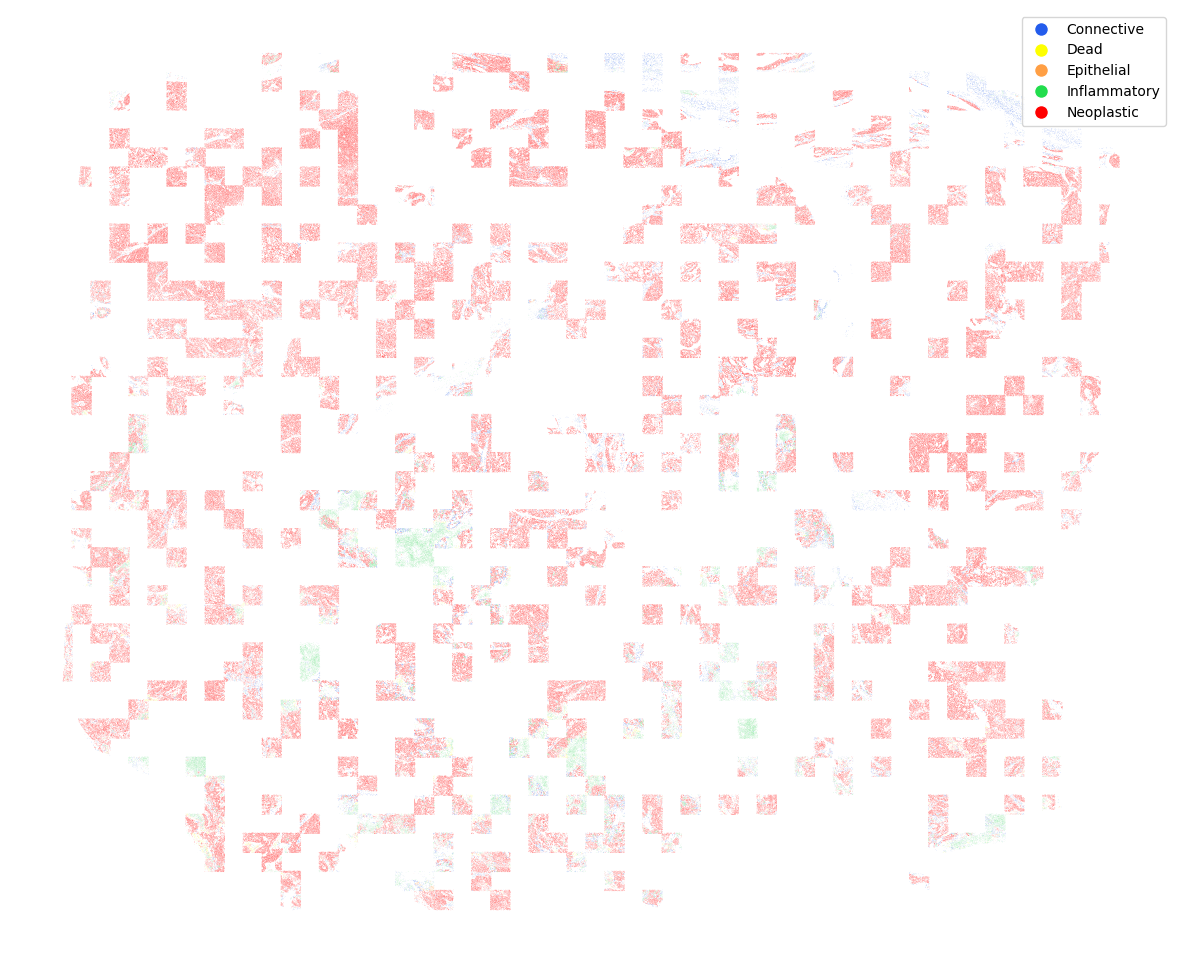

In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

color_dict = {
    "Connective": "#235cec",
    "Dead": "#feff00",
    "Epithelial": "#ff9f44",
    "Inflammatory": "#22dd4d",
    "Neoplastic": "#ff0000",
}
legend_name_dict = {
    "Connective": "Connective",
    "Dead": "Dead",
    "Epithelial": "Epithelial",
    "Inflammatory": "Inflammatory",
    "Neoplastic": "Neoplastic",
}

fig, ax = plt.subplots(figsize=(15, 15))
for class_name, color in color_dict.items():
    subset = cells.gdf[cells.gdf['class_name'] == class_name]
    if not subset.empty:
        subset.plot(
            ax=ax,
            color=color,
            label=legend_name_dict[class_name]
        )
plt.gca().invert_yaxis()
plt.axis("off")

# 手动构造带圆点的 legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=legend_name_dict[class_name],
           markerfacecolor=color, markersize=10)
    for class_name, color in color_dict.items()
]
plt.legend(handles=legend_elements, fontsize=10, loc="upper right")

plt.show()

In [5]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from typing import List, Dict, Tuple
from shapely.geometry import LineString, Polygon

__all__ = [
    "cell_counts",
    "cell_features",
    "cell_percentages",
    "shannon_index",
    "geo_area",
    "geo_solidity",
    "geo_eccentricity",
    "geo_rotation",
    "geo_roundness",
    "geo_axis",
    "geo_perimeter",
    "geoSferVolume",
    "geoEllisVolume"
]


def cell_counts(
    ref_cells: gpd.GeoDataFrame,
) -> Tuple[Dict[str, int], List[Polygon], List[str]]:
    """Count the cells of different types.

    I.e. count how many neoplastic, inflammatory and connective cells are
    in the entire WSI.

    Parameters
    ----------
        ref_cells : gpd.GeoDataFrame
            A geo-dataframe containing the info of the cells.

    Returns
    -------
        Tuple[Dict[str, int], List[Polygon], List[str]]:
            Dict mapping celltypes to counts,
            a list of the cell polygos (len = n_cells)
            a list of the celltypes (len = n_cells)
    """
    cells_list = []
    poly_list = []
    for i in range(0, len(ref_cells)):
        poly_list.append(ref_cells.geometry.iloc[i])
        #cells_list.append(ref_cells.properties[i]["classification"]["name"])
    cells_list = list(ref_cells["properties"].apply(
        lambda x: x["classification"]["name"]))

    unique, counts = np.unique(np.array(cells_list), return_counts=True)
    #data = dict(
    #    zip(
    #        ["Neoplastic", "Inflammatory", "Connective"],
    #        [
    #            counts[np.where(unique == "Neoplastic")][0],
    #            counts[np.where(unique == "Inflammatory")][0],
    #            counts[np.where(unique == "Connective")][0],
    #        ],
    #    )
    #)
    data = dict(zip(unique, counts))
    return data, poly_list, cells_list


def cell_features(ref_cells: gpd.GeoDataFrame) -> pd.DataFrame:
    """Extract morphological feature sfrom the cells.

    Parameters
    ----------
        ref_cells : gpd.GeoDataFrame
            A geo-dataframe containing the info of the cells.

    Returns
    -------
        pd.DataFrame:
            A dataframe containing the features.
    """
    data, cells_list, _ =cell_counts(ref_cells)
    with Pool(cpu_count()) as pool:
        mbrs = pool.map(get_mrr, cells_list)

    cell_types = ref_cells["properties"].apply(
                lambda x: x["classification"]["name"]
            )
    areas = geo_area(cells_list)
    convex_areas = geo_convex_area(cells_list)
    extent = geo_extent(cells_list, areas)
    sf_volume = geoSferVolume(areas)
    el_volume = geoEllisVolume(cells_list, mbrs)
    solidity = geo_solidity(cells_list)
    eccentricity = geo_eccentricity_parallel(cells_list, mbrs)
    rotation = geo_rotation(mbrs)
    minor_axis, major_axis, aspect_ratio = geo_axis_parallel(cells_list, mbrs)
    roundness = geo_roundness(mbrs, areas)
    perimeter = geo_perimeter(cells_list)
    poly_list = list(zip(
        cell_types, areas, convex_areas, extent, sf_volume, el_volume, solidity, 
        eccentricity, rotation, minor_axis, major_axis,
        aspect_ratio, roundness, perimeter
    ))
    #for i in range(0, len(ref_cells)):
    #    geom = [ref_cells.geometry.iloc[i]]
    #    minor_axis, major_axis, aspect_ratio = geo_axis(geom)

    #    poly_list.append(
    #        [
    #            ref_cells.properties.iloc[i]["classification"]["name"],
    #            geo_area(geom)[0],
    #            geoSferVolume(geom)[0],\
    #            geoEllisVolume(geom)[0],\
    #            geo_solidity(geom)[0],
    #            geo_eccentricity(geom)[0],
    #            geo_rotation(geom)[0],
    #            minor_axis[0],
    #            major_axis[0],
    #            aspect_ratio[0],
    #            geo_roundness(geom)[0],
    #            geo_perimeter(geom)[0],
    #        ]
    #    )
    df = pd.DataFrame(
        poly_list,
        columns=[
            "CellType",
            "Area",
            "Convex_area",
            "Extent",
            "Sf_Volume",
            "El_Volume",
            "Solidity",
            "Eccentricity",
            "Rotation",
            "MinorAxis",
            "MajorAxis",
            "Aspect ratio",
            "Roundness",
            "Perimeter",
        ],
    )
    return df


def cell_percentages(data: Dict[str, int]) -> Dict[str, float]:
    """Calculate the percentage of different celltypes.

    I.e the cell percentages for neoplastic, inflammatory and connective cell counts

    Parameters
    ----------
        data : Dict[str, int]
            Dict mapping celltypes to counts.

    Returns
    -------
        Dict[str, float]:
            A Dict mapping celltypes to normalized counts
    """
    N = sum(data.values())
    norm_data = data
    norm_data = {k: v / N for k, v in norm_data.items()}

    return norm_data


def shannon_index(data: Dict[str, int]) -> float:
    """Compute shannon index from cellcounts per type.

    Parameters
    ----------
        data : Dict[str, int]
            Dict mapping celltypes to counts.

    Returns
    -------
        float:
            The shannon index value.
    """

    def p(n, N):
        if n == 0:
            return 0
        else:
            return (float(n) / N) * np.log10(float(n) / N)

    N = sum(data.values())
    return -sum(p(n, N) for n in data.values() if n != 0)


def geo_area(cells_list: List[Polygon]) -> List[float]:
    """Compute the cell areas.

    Parameters
    ----------
        cells_list : List[Polygon]
            A list of shapely polygons representing cells.

    Returns
    -------
        List[float]:
            The cell areas in a list.
    """
    #areas = []
    cells_list = gpd.GeoSeries(cells_list)
    areas = cells_list.area.values.tolist()
    #for i in range(0, len(cells_list)):
    #    areas.append(cells_list[i].area)
    return areas

def geo_convex_area(cells_list):
    """Compute the convex hull area of each cell"""
    cells_list = gpd.GeoSeries(cells_list)
    convex_areas = cells_list.convex_hull.area.values.tolist()
    return convex_areas

def geo_extent(cells_list, areas):
    """Compute the extent of each cell"""
    cells_list = gpd.GeoSeries(cells_list)
    bbox_areas = cells_list.geometry.envelope.area
    extent = (areas / bbox_areas).values.tolist()
    return extent


def geo_solidity(cells_list: List[Polygon]) -> List[float]:
    """Compute the solidity feature of the cells.

    Parameters
    ----------
        cells_list : List[Polygon]
            A list of shapely polygons representing cells.

    Returns
    -------
        List[float]:
            The cell solidities in a list.
    """
    #solidit = []
    cells_list = gpd.GeoSeries(cells_list)
    solidit = (cells_list.area / cells_list.convex_hull.area).tolist()
    #for i in range(0, len(cells_list)):
    #    solidit.append((cells_list[i].area) / ((cells_list[i].convex_hull).area))

    return solidit


def geo_eccentricity(cells_list: List[Polygon]) -> List[float]:
    """Compute the eccentricity of the cells.

    Parameters
    ----------
        cells_list : List[Polygon]
            A list of shapely polygons representing cells.

    Returns
    -------
        List[float]:
            The cell eccentricities in a list.
    """
    eccentr = []
    for i in range(0, len(cells_list)):
        points = list(zip(*cells_list[i].minimum_rotated_rectangle.exterior.coords.xy))
        lengths = [
            LineString((points[j], points[j + 1])).length
            for j in range(len(points) - 1)
        ]

        # get major/minor axis measurements
        min_axis = min(lengths)
        max_axis = max(lengths)
        a = max_axis / 2
        b = min_axis / 2

        eccentr.append(np.sqrt(np.square(a) - np.square(b)) / a)

    return eccentr

def eccentricity_from_mrr(mbr):
    points = list(zip(*mbr.exterior.coords.xy))
    lengths = [
        LineString((points[j], points[j + 1])).length
        for j in range(len(points) - 1)
    ]
    min_axis = min(lengths)
    max_axis = max(lengths)
    a = max_axis / 2
    b = min_axis / 2
    if a == 0:
        return 0
    return np.sqrt(a**2 - b**2) / a

def geo_eccentricity_parallel(cells_list, mbrs):
    with Pool(cpu_count()) as pool:
        eccentr = pool.map(eccentricity_from_mrr, mbrs)
    return eccentr

def rotation_from_mrr(mrr):
    rect = np.array(mrr.exterior.coords)
    edges = []
    for d in np.diff(rect, axis=0):
        length = np.sqrt(d[0] ** 2 + d[1] ** 2)
        angle = np.arctan2(d[1], d[0])
        edges.append([length, angle])
    edges = np.array(edges)
    angle_value = edges[np.argmax(edges[:, 0])][1]
    if angle_value > np.pi / 2:
        angle_value -= np.pi
    elif angle_value < -np.pi / 2:
        angle_value += np.pi
    return angle_value

def geo_rotation(mbrs) -> List[float]:
    """Compute the rotation of the cells.

    Parameters
    ----------
        cells_list : List[Polygon]
            A list of shapely polygons representing cells.

    Returns
    -------
        List[float]:
            The cell rotations in a list.
    """
    with Pool(cpu_count()) as pool:
        rot_ang = pool.map(rotation_from_mrr, mbrs)

    return rot_ang


def geo_axis(cells_list: List[Polygon]) -> Tuple[List[float], List[float], List[float]]:
    """Compute minor and major axes and aspect ratio of the cells.

    Parameters
    ----------
        cells_list : List[Polygon]
            A list of shapely polygons representing cells.

    Returns
    -------
        Tuple[List[float], List[float], List[float]]
            The minor axis of the cells in a list.
            The major axis of the cells in a list.
            The aspect ratio of the cells in a list.
    """
    cells_list = gpd.GeoSeries(cells_list)
    mbrs = cells_list.minimum_rotated_rectangle()
    def get_axes(mbr):
        mbr_points = list(zip(*mbr.exterior.coords.xy))
        mbr_lengths = [
            LineString((mbr_points[i], mbr_points[i+1])).length
            for i in range(len(mbr_points) - 1)
        ]
        min_len = min(mbr_lengths)
        max_len = max(mbr_lengths)
        return min_len, max_len, max_len / min_len
    results = [get_axes(mbr) for mbr in mbrs]
    minor_axis, major_axis, aspect_ratio = zip(*results)
    #minor_axis = []
    #major_axis = []
    #aspect_ratio = []
    #for i in range(0, len(cells_list)):
    #    mbr_points = list(
    #        zip(*cells_list[i].minimum_rotated_rectangle.exterior.coords.xy)
    #    )

    #    # calculate the length of each side of the minimum bounding rectangle
    #    mbr_lengths = [
    #        LineString((mbr_points[i], mbr_points[i + 1])).length
    #        for i in range(len(mbr_points) - 1)
    #    ]

    #    # get major/minor axis measurements
    #    minor_axis.append(min(mbr_lengths))
    #    major_axis.append(max(mbr_lengths))
    #    aspect_ratio.append(max(mbr_lengths) / min(mbr_lengths))
    return list(minor_axis), list(major_axis), list(aspect_ratio)

    #return minor_axis, major_axis, aspect_ratio

def get_mrr(cell):
    return cell.minimum_rotated_rectangle

def get_axes(mbr):
    mbr_points = list(zip(*mbr.exterior.coords.xy))
    mbr_lengths = [
        LineString((mbr_points[i], mbr_points[i + 1])).length
        for i in range(len(mbr_points) - 1)
    ]
    min_len = min(mbr_lengths)
    max_len = max(mbr_lengths)
    return min_len, max_len, max_len / min_len

def geo_axis_parallel(cells_list, mbrs):
    cells_list = gpd.GeoSeries(cells_list)
    # 并行计算最小外接矩形
    #with Pool(cpu_count()) as pool:
    #    mbrs = pool.map(get_mrr, cells_list)
    # 并行计算轴
    with Pool(cpu_count()) as pool:
        results = pool.map(get_axes, mbrs)
    minor_axis, major_axis, aspect_ratio = zip(*results)
    return list(minor_axis), list(major_axis), list(aspect_ratio)

def roundness_from_mrr(args):
    mbr, area = args
    mbr_points = list(zip(*mbr.exterior.coords.xy))
    mbr_lengths = [LineString((mbr_points[i], mbr_points[i+1])).length
                   for i in range(len(mbr_points)-1)]
    major_axis = max(mbr_lengths)
    return 4 * (area / (math.pi * (major_axis ** 2)))

def geo_roundness(mbrs, areas) -> List[float]:
    """Compute the roundness of the cells.

    Parameters
    ----------
        cells_list : List[Polygon]
            A list of shapely polygons representing cells.

    Returns
    -------
        List[float]:
            The cell roundnesses in a list.
    """
    with Pool(cpu_count()) as pool:
        roundness = pool.map(roundness_from_mrr, zip(mbrs, areas))

    return roundness


def geo_perimeter(cells_list: List[Polygon]) -> List[float]:
    """Compute the perimeters of the cells.

    Parameters
    ----------
        cells_list : List[Polygon]
            A list of shapely polygons representing cells.

    Returns
    -------
        List[float]:
            The cell perimeters in a list.
    """
    #perimeter = []
    #for i in range(0, len(cells_list)):
    #    perimeter.append(cells_list[i].length)
    cells_list = gpd.GeoSeries(cells_list)
    perimeter = cells_list.length.values.tolist()

    return perimeter


def geo_pa_ratio(areas, perimeters):
    pa_ratio = (perimeters ** 2) / areas if areas > 0 else 0

def geoSferVolume(areas) -> List[float]:
    """Compute the volume with sphere formula of the cells.

    Parameters
    ----------
        cells_list : List[Polygon]
            A list of shapely polygons representing cells.

    Returns
    -------
        List[float]:
            The cell perimeters in a list.
    """
    #volume=[]
    #for i in range(0,len(cells_list)):
    #    areas=cells_list[i].area
    #    radius = math.sqrt(areas / (4 * math.pi))
    #    V=(4/3)*math.pi * (radius ** 3)
    #    volume.append(V)
    volume = [
        (4/3) * math.pi * (math.sqrt(a / (4 * math.pi)) ** 3)
        for a in areas
    ]
    return volume

def geoEllisVolume(cells_list: List[Polygon], mbrs) -> List[float]:
    """Compute the volume with ellipsoid formula of the cells.

    Parameters
    ----------
        cells_list : List[Polygon]
            A list of shapely polygons representing cells.

    Returns
    -------
        List[float]:
            The cell perimeters in a list.
    """
    volume=[]
    #minor_axis,major_axis,aspect_ratio=geo_axis(cells_list)
    minor_axis,major_axis,aspect_ratio=geo_axis_parallel(cells_list, mbrs)
    for i in range(0,(len(minor_axis))): 
        V= (4/3) * math.pi * ((minor_axis[i]/2) ** 2) * major_axis[i]/2
        volume.append(V)
    return volume


def geo_pa_ratio(areas, perimeters):
    areas = np.array(areas)
    perimeters = np.array(perimeters)
    pa_ratio = list(np.where(np.array(areas) > 0, 
               (np.array(perimeters) ** 2) / np.array(areas), 
               0))
    return pa_ratio


def get_patch_coordinates(patch_geojsonpath, yaml_file_path):
    patch_geojsonpath = patch_geojsonpath.strip(".geojson")
    patch_size, patch_overlap = read_config_params(yaml_file_path)
    stride = int(patch_size - patch_size * patch_overlap / 100.)
    row = int(patch_geojsonpath.split("/")[-1].split("_")[-2])
    col = int(patch_geojsonpath.split("/")[-1].split("_")[-1])
    
    x = col * stride
    y = row * stride
    return x, y


def read_config_params(yaml_file_path):
    with open(yaml_file_path, "r", encoding="utf-8") as f:
        config = yaml.safe_load(f)

    patch_size = config.get("patch_size")
    patch_overlap = config.get("patch_overlap")
    return patch_size, patch_overlap


def cell_features_for_patch(ref_cells: gpd.GeoDataFrame, patch_geojsonpath, yaml_file_path) -> pd.DataFrame:
    """Extract morphological feature sfrom the cells for patch.

    Parameters
    ----------
        ref_cells : gpd.GeoDataFrame
            A geo-dataframe containing the info of the cells.

    Returns
    -------
        pd.DataFrame:
            A dataframe containing the features.
    """
    data, cells_list, _ =cell_counts(ref_cells)
    coordinate_xy = list(ref_cells["properties"].apply(
        lambda x: x["measurements"]["centroid"]
    ))
    coordinate_x = [i[0] for i in coordinate_xy]
    coordinate_y = [i[1] for i in coordinate_xy]
    probability = list(ref_cells["properties"].apply(
        lambda x: x["measurements"]["probability"]
    ))
    coordinate_x_patch, coordinate_y_patch = get_patch_coordinates(patch_geojsonpath, yaml_file_path)
    with Pool(cpu_count()) as pool:
        mbrs = pool.map(get_mrr, cells_list)

    cell_types = ref_cells["properties"].apply(
                lambda x: x["classification"]["name"]
            )
    areas = geo_area(cells_list)
    convex_areas = geo_convex_area(cells_list)
    extent = geo_extent(cells_list, areas)
    sf_volume = geoSferVolume(areas)
    el_volume = geoEllisVolume(cells_list, mbrs)
    solidity = geo_solidity(cells_list)
    eccentricity = geo_eccentricity_parallel(cells_list, mbrs)
    rotation = geo_rotation(mbrs)
    minor_axis, major_axis, aspect_ratio = geo_axis_parallel(cells_list, mbrs)
    roundness = geo_roundness(mbrs, areas)
    perimeter = geo_perimeter(cells_list)
    coordinate_x_patch = [coordinate_x_patch] * len(areas)
    coordinate_y_patch = [coordinate_y_patch] * len(areas)
    pa_ratio = geo_pa_ratio(areas, perimeter)
    poly_list = list(zip(
        cell_types, probability, areas, convex_areas, extent, sf_volume, el_volume, solidity, 
        eccentricity, rotation, minor_axis, major_axis,
        aspect_ratio, roundness, perimeter, pa_ratio, coordinate_x, coordinate_y, coordinate_x_patch, coordinate_y_patch
    ))
    #for i in range(0, len(ref_cells)):
    #    geom = [ref_cells.geometry.iloc[i]]
    #    minor_axis, major_axis, aspect_ratio = geo_axis(geom)

    #    poly_list.append(
    #        [
    #            ref_cells.properties.iloc[i]["classification"]["name"],
    #            geo_area(geom)[0],
    #            geoSferVolume(geom)[0],\
    #            geoEllisVolume(geom)[0],\
    #            geo_solidity(geom)[0],
    #            geo_eccentricity(geom)[0],
    #            geo_rotation(geom)[0],
    #            minor_axis[0],
    #            major_axis[0],
    #            aspect_ratio[0],
    #            geo_roundness(geom)[0],
    #            geo_perimeter(geom)[0],
    #        ]
    #    )
    df = pd.DataFrame(
        poly_list,
        columns=[
            "CellType",
            "Probability",
            "Area",
            "Convex_area",
            "Extent",
            "Sf_Volume",
            "El_Volume",
            "Solidity",
            "Eccentricity",
            "Rotation",
            "MinorAxis",
            "MajorAxis",
            "Aspect ratio",
            "Roundness",
            "Perimeter",
            "Pa_ratio",
            "coordinate_x",
            "coordinate_y",
            "coordinate_x_patch",
            "coordinate_y_patch"
        ],
    )
    return df

In [6]:
#cellDoc = pd.read_json("./nulite_inference/CMU-1/cell_detection/cells.geojson")
#cellDoc = pd.read_json("/home/stat-caolei/code/NuLite/nulite_inference/CMU-1/cell_detection/patch_geojson/cells_patch_1_31.geojson")
cellDoc = pd.read_json("/home/stat-caolei/code/MIA/data/wsi_output/CMU-1/cell_detection/patch_geojson/cells_patch_1_31.geojson")
cellDoc["geometry"] = cellDoc["geometry"].apply(shapely.geometry.shape)
cells = gpd.GeoDataFrame(cellDoc).set_geometry("geometry")
cells = cells.explode(index_parts=False)
#cells["class_name"] = cells["properties"].apply(
#                lambda x: x["classification"]["name"]
#            )
cells

type                                    id  \
0    Feature  d95c7eae-5a4d-478f-8bc3-0c9be34d5f8f   
1    Feature  9050bdb8-412c-4a0b-a80e-d2e542adb3ad   
2    Feature  feeccae4-f975-4762-98b8-df1fed9cd17e   
3    Feature  2ab0dee9-2bf3-42bb-9a13-68095b5b82b5   
4    Feature  0b22213a-ff71-43f4-9609-fe4b3e0a7756   
..       ...                                   ...   
526  Feature  a6c074cc-772d-4e18-b08c-df4986b05a50   
527  Feature  0378b6c9-c743-4a21-bfef-7c9df1c9b24b   
528  Feature  ca49edaf-6739-41f7-91b5-7210a9b6f192   
529  Feature  dfaf6dbd-8135-4c9c-a545-e13f008261c5   
530  Feature  19a69b88-ab9f-4014-ba62-a4fe4ce93907   

                                            properties  \
0    {'objectType': 'annotation', 'classification':...   
1    {'objectType': 'annotation', 'classification':...   
2    {'objectType': 'annotation', 'classification':...   
3    {'objectType': 'annotation', 'classification':...   
4    {'objectType': 'annotation', 'classification':...   
..                                                 ...   
526  {'objectType': 'annotation', 'classification':...   
527  {'objectType': 'annotation', 'classification':...   
528  {'objectType': 'annotation', 'classification':...   
529  {'objectType': 'annotation', 'classification':...   
530  {'objectType': 'annotation', 'classification':...   

                                              geometry  
0    POLYGON ((30258.000 1128.000, 30257.000 1129.0...  
1    POLYGON ((30277.000 1147.000, 30275.000 1149.0...  
2    POLYGON ((29778.000 1157.000, 29777.000 1158.0...  
3    POLYGON ((30267.000 1159.000, 30264.000 1162.0...  
4    POLYGON ((29833.000 1169.000, 29832.000 1170.0...  
..                                                 ...  
526  POLYGON ((30140.000 1887.000, 30137.000 1890.0...  
527  POLYGON ((30388.000 1887.000, 30385.000 1890.0...  
528  POLYGON ((30014.000 1881.000, 30013.000 1882.0...  
529  POLYGON ((30624.000 1899.000, 30624.000 1900.0...  
530  POLYGON ((30375.000 1928.000, 30374.000 1929.0...  

[531 rows x 4 columns]

In [13]:
# Function to extract information regarding the numbers of Neoplastic, Inflammatory and Connective cells present in the WSI slide
data, cells_list, poly_list=cell_counts(cells)
print(data)

{'Connective': 159, 'Epithelial': 343, 'Inflammatory': 236, 'Neoplastic': 25}


In [15]:
# Function to extract the percentage of Neoplastic, Inflammatory and Connective cells present in the WSI slide
norm_data=cell_percentages(data)
print(norm_data)
#print('Neoplastic percentage: %.3f\nInflammatory percentage: %.3f\nConnective percentage: %.3f' %(norm_data['Neoplastic'],norm_data['Inflammatory'],norm_data['Connective']))

{'Connective': 0.035781544256120526, 'Epithelial': 0.8700564971751412, 'Inflammatory': 0.09416195856873823}


In [6]:
# Function to extract the Shannon Index
ShannonIndex=shannon_index(data)        
print('Shannon Index: %.3f'% ShannonIndex)

Shannon Index: 0.201


In [10]:
with Pool(cpu_count()) as pool:
    mbrs = pool.map(get_mrr, cells_list)

In [11]:
# Morphological features extraction from cells
#Area
areas=geo_area(cells_list)

In [66]:
convex_area = geo_convex_area(cells_list)

In [67]:
extent = geo_extent(cells_list, areas)

In [68]:
sfvolume = geoSferVolume(areas)

In [37]:
solidity = geo_solidity(cells_list)

In [39]:
# Volume
S_volume=geoEllisVolume(cells_list, mbrs)

In [40]:
#Eccentricity 
eccentr=geo_eccentricity_parallel(cells_list, mbrs)

In [41]:
#Rotation
rot_ang=geo_rotation(mbrs)

In [42]:
#Minor Axis, Major Axis and Aspect Ratio
minor_axis, major_axis, aspect_ratio=geo_axis_parallel(cells_list, mbrs)

In [56]:
#Roundness
roundness=geo_roundness(mbrs, areas)

In [12]:
#Perimeter
perimeter=geo_perimeter(cells_list)

In [49]:
sf_volume=geoSferVolume(areas)

In [20]:
# Function to obtain all the features in one variable
cell_feat=cell_features(cells)
cell_feat.head()

CellType   Area  Convex_area    Extent  Sf_Volume   El_Volume  \
0  Inflammatory   69.5         71.5  0.827381  54.481746  263.893783   
1  Inflammatory  102.5        106.0  0.759259  97.579730  636.172512   
2  Inflammatory   68.0         71.5  0.772727  52.727500  368.613538   
3  Inflammatory   88.5         93.5  0.614583  78.286832  506.488655   
4  Inflammatory   92.5         95.5  0.777311  83.653942  436.157780   

   Solidity  Eccentricity  Rotation  MinorAxis  MajorAxis  Aspect ratio  \
0  0.972028      0.903508  1.570796   6.000000  14.000000      2.333333   
1  0.966981      0.800000  1.570796   9.000000  15.000000      1.666667   
2  0.951049      0.686349  1.570796   8.000000  11.000000      1.375000   
3  0.946524      0.775312  0.785398   8.485281  13.435029      1.583333   
4  0.968586      0.911290  1.570796   7.000000  17.000000      2.428571   

   Roundness  Perimeter  
0   0.451480  34.727922  
1   0.580031  40.384776  
2   0.715540  32.142136  
3   0.624275  38.041631  
4   0.407525  41.556349

In [10]:
cell_feat.tail()

NameError: name 'cell_feat' is not defined

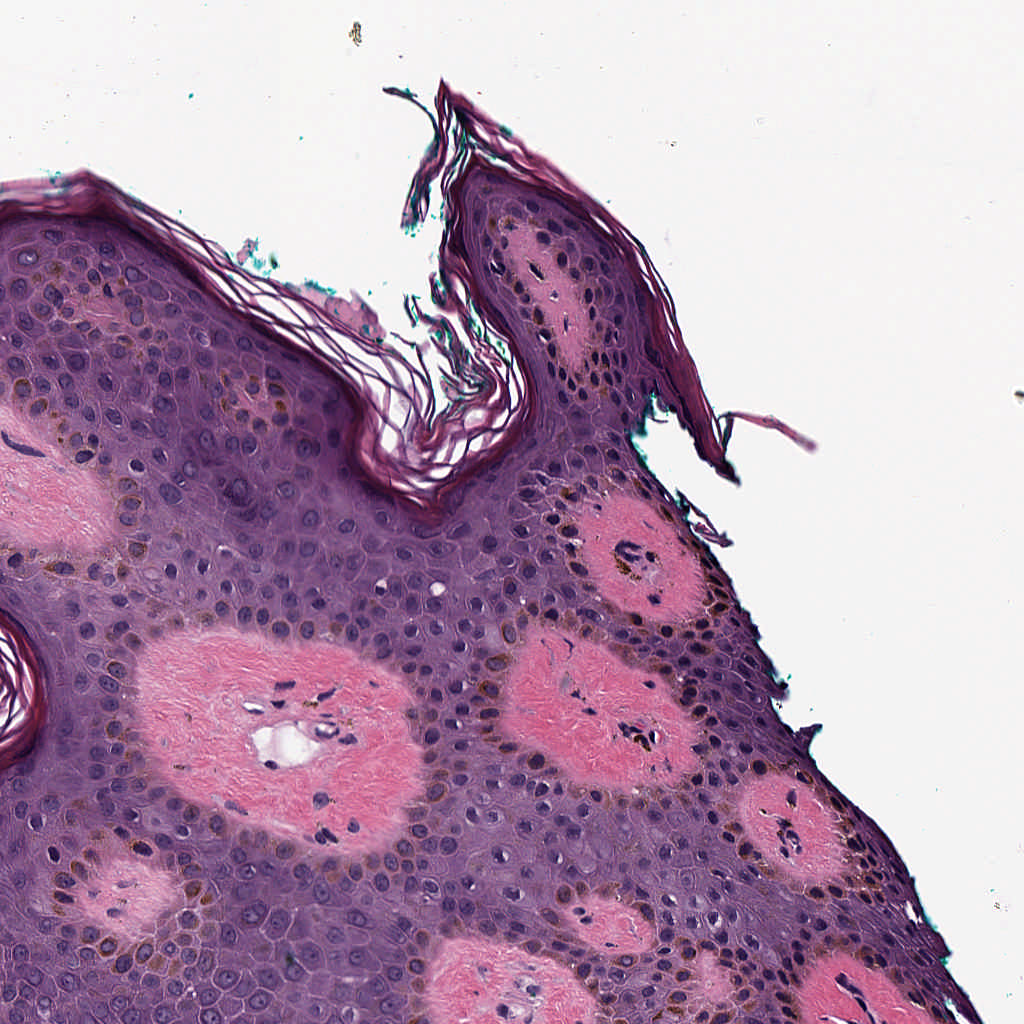

In [18]:
import openslide


patch_size = 1024
patch_overlap = 6.25
overlap = patch_size * patch_overlap / 100.

row = 1  # 举例
col = 31  # 举例

wsi_scaling_factor = 1
x = int(
            row * patch_size * wsi_scaling_factor
            - (row + 0.5) * overlap
            )
y = int(
            col * patch_size * wsi_scaling_factor
            - (col + 0.5) * overlap
            )
slide = openslide.open_slide("./data/wsi/CMU-1.svs")
image = slide.read_region((y, x), level=0, size=(patch_size, patch_size))
image

In [7]:
#patch_geojsonpath = "/home/stat-caolei/code/NuLite/nulite_inference/CMU-1/cell_detection/patch_geojson/cells_patch_1_31.geojson"
patch_geojsonpath = "/home/stat-caolei/code/MIA/data/wsi_output/CMU-1/cell_detection/patch_geojson/cells_patch_1_31.geojson"
yaml_file_path = "/home/stat-caolei/code/MIA/preprocessing/config_examples/preprocessing_example.yaml"
cell_feat_patch = cell_features_for_patch(cells, patch_geojsonpath, yaml_file_path)

In [8]:
cell_feat_patch.head()

CellType  Probability   Area  Convex_area    Extent   Sf_Volume  \
0  Epithelial     0.992308  112.0        115.5  0.717949  111.455331   
1  Epithelial     1.000000  148.0        154.5  0.657778  169.303675   
2  Epithelial     1.000000  209.5        221.0  0.698333  285.134556   
3  Epithelial     0.953333  130.0        135.5  0.714286  139.376271   
4  Epithelial     1.000000  183.5        189.5  0.764583  233.737242   

     El_Volume  Solidity  Eccentricity  Rotation  MinorAxis  MajorAxis  \
0   725.670880  0.969697      0.714143  0.785398   9.899495  14.142136   
1  1105.986831  0.957929      0.810769  0.463648  10.733126  18.335757   
2  2214.898219  0.947964      0.708329  0.643501  14.400000  20.400000   
3  1024.452148  0.959410      0.699854  0.463648  11.180340  15.652476   
4  1884.955592  0.968338      0.347985  1.570796  15.000000  16.000000   

   Aspect ratio  Roundness  Perimeter   Pa_ratio  coordinate_x  coordinate_y  \
0      1.428571   0.713014  40.627417  14.737384  30260.500000   1134.292308   
1      1.708333   0.560498  49.455844  16.526220  30282.029412   1154.741176   
2      1.416667   0.640964  57.698485  15.890764  29781.702128   1164.093617   
3      1.400000   0.675596  44.627417  15.320049  30270.820000   1165.573333   
4      1.066667   0.912654  52.041631  14.759299  29834.898551   1177.067633   

   coordinate_x_patch  coordinate_y_patch  
0               29760                 960  
1               29760                 960  
2               29760                 960  
3               29760                 960  
4               29760                 960

In [9]:
cell_feat_patch.tail()

CellType  Probability   Area  Convex_area    Extent   Sf_Volume  \
526    Epithelial         1.00  177.0        180.0  0.842857  221.428599   
527    Epithelial         1.00  131.5        134.0  0.796970  141.795498   
528    Epithelial         1.00  359.5        394.5  0.641964  640.947053   
529  Inflammatory         0.84   60.0         63.5  0.625000   43.701937   
530    Epithelial         1.00   38.0         39.0  0.775510   22.026688   

       El_Volume  Solidity  Eccentricity  Rotation  MinorAxis  MajorAxis  \
526  1539.380400  0.983333      0.359011  0.000000  14.000000  15.000000   
527   950.331778  0.981343      0.679869  0.000000  11.000000  15.000000   
528  5610.670450  0.911280      0.739119  0.837981  19.325648  28.691154   
529   275.372737  0.944882      0.884433  1.107149   6.260990  13.416408   
530   179.594380  0.974359      0.000000  1.570796   7.000000   7.000000   

     Aspect ratio  Roundness  Perimeter   Pa_ratio  coordinate_x  \
526      1.071429   1.001615  49.798990  14.010957  30144.405000   
527      1.363636   0.744138  43.213203  14.200616  30391.807947   
528      1.484615   0.556049  81.840620  18.631119  30020.600000   
529      2.142857   0.424413  32.970563  18.117633  30626.906667   
530      1.000000   0.987410  23.313708  14.303395  30377.428571   

     coordinate_y  coordinate_x_patch  coordinate_y_patch  
526   1894.010000               29760                 960  
527   1892.602649               29760                 960  
528   1896.645570               29760                 960  
529   1905.213333               29760                 960  
530   1931.122449               29760                 960

In [27]:
cell_feat_patch['Eccentricity'].mean()

0.5991531560957242

In [36]:
def get_edge_type(edge, cell_type):
    """
    Args:
        edge: (in_cell_index, out_cell_index, 1/edge_length)
    Returns:
        edge type index.
    """
    mapping = {
        "1-1": 0, "1-2": 1, "1-3": 2, "1-4": 3, "1-5": 4,
        "2-1": 5, "2-2": 6, "2-3": 7, "2-4": 8, "2-5": 9,
        "3-1": 10, "3-2": 11, "3-3": 12, "3-4": 13, "3-5": 14,
        "4-1": 15, "4-2": 16, "4-3": 17, "4-4": 18, "4-5": 19,
        "5-1": 20, "5-2": 21, "5-3": 22, "5-4": 23, "5-5": 24
    }
    return mapping["{}-{}".format(cell_type[edge[0]], cell_type[edge[1]])]


def get_nuclei_orientation_diff(edge, nuclei_orientation):
    return np.cos(nuclei_orientation[edge[0]] - nuclei_orientation[edge[1]])

In [12]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse as sp
import networkx as nx
from torch_geometric.utils.convert import to_networkx

/home/stat-caolei/miniconda3/envs/HEIP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
from sklearn.neighbors import NearestNeighbors


def filter_isolated_cells(coordinates, min_neighbors=1, radius=50):
    """过滤掉周围邻居数量不足的孤立细胞"""
    nn = NearestNeighbors(radius=radius)
    nn.fit(coordinates)

    # 计算每个点在指定半径内的邻居数量
    neighbor_counts = []
    for i, coord in enumerate(coordinates):
        neighbors = nn.radius_neighbors([coord], return_distance=False)[0]
        neighbor_counts.append(len(neighbors) - 1)

    # 保留邻居数量充足的点
    valid_mask = np.array(neighbor_counts) >= min_neighbors
    return valid_mask


# 获取细胞的坐标
coordinates = np.array(cell_feat_patch[["coordinate_x", "coordinate_y"]])

# 过滤掉孤立的细胞
valid_mask = filter_isolated_cells(coordinates)
cell_feat_patch = cell_feat_patch[valid_mask]

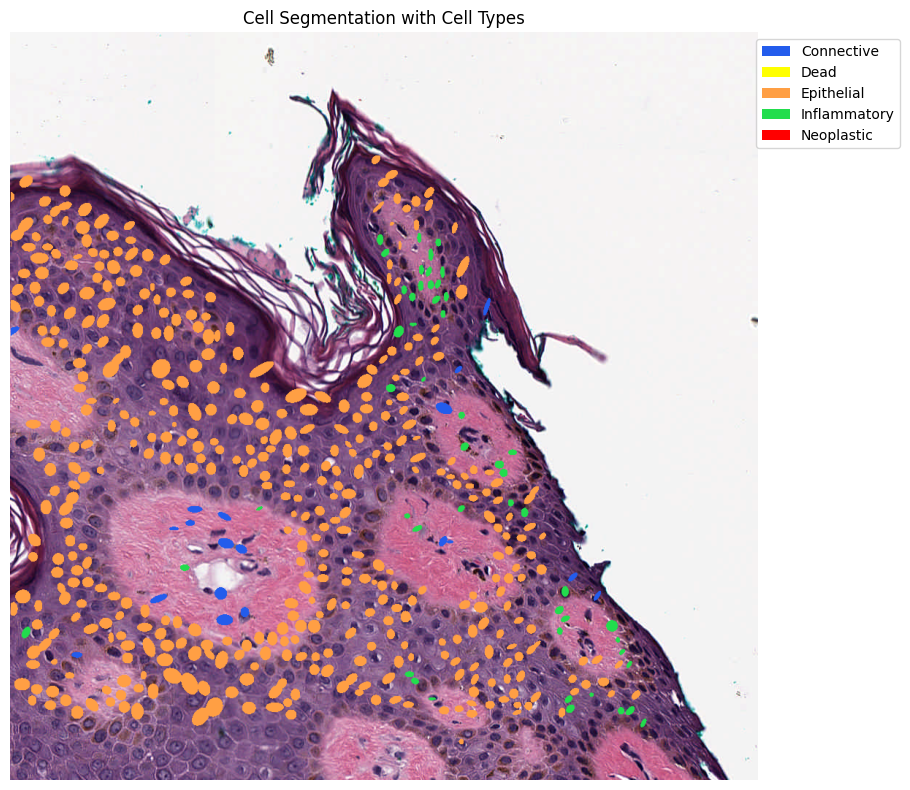

In [19]:
# Reconstruct segmentation with updated colors and legend
import skimage
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Updated color dictionary with hex colors
color_dict = {
    "Connective": "#235cec",
    "Dead": "#feff00", 
    "Epithelial": "#ff9f44",
    "Inflammatory": "#22dd4d",
    "Neoplastic": "#ff0000",
}

# Convert hex colors to RGB for image processing
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]

# Create RGB color dictionary for image pixel assignment
color_dict_rgb = {k: hex_to_rgb(v) for k, v in color_dict.items()}

h, w = 1024, 1024
image = np.array(image)[..., :3]
roi_pred_image = image.copy()

for index, (_, cell) in enumerate(cell_feat_patch.iterrows()):
    y, x = skimage.draw.ellipse(cell['coordinate_x'] - cell['coordinate_x_patch'], 
                                cell['coordinate_y'] - cell['coordinate_y_patch'], 
                                cell['MajorAxis']/2, cell['MinorAxis']/2, 
                                rotation=-cell['Rotation'])
    c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
    x, y = x[c], y[c]
    roi_pred_image[x, y, :] = color_dict_rgb[cell['CellType']]

# Create the plot with legend
plt.figure(figsize=(10, 8))
plt.imshow(roi_pred_image)

# Create legend using the hex colors
legend_elements = [Patch(facecolor=color, label=cell_type) 
                  for cell_type, color in color_dict.items()]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.title('Cell Segmentation with Cell Types')
plt.axis('off')  # Remove axes for cleaner visualization
plt.tight_layout()
plt.show()

In [13]:
graph = kneighbors_graph(
    np.array(cell_feat_patch[["coordinate_x", "coordinate_y"]]),
    n_neighbors=8, mode="distance"
)
# 获取边的信息
I, J, V = sp.find(graph)
edges = list(zip(I, J, 1/V))
edge_index = np.transpose(np.array(edges)[:, 0:2])
pos = np.array(cell_feat_patch.loc[:, ['coordinate_x', 'coordinate_y']])
cell_types = cell_feat_patch['CellType']

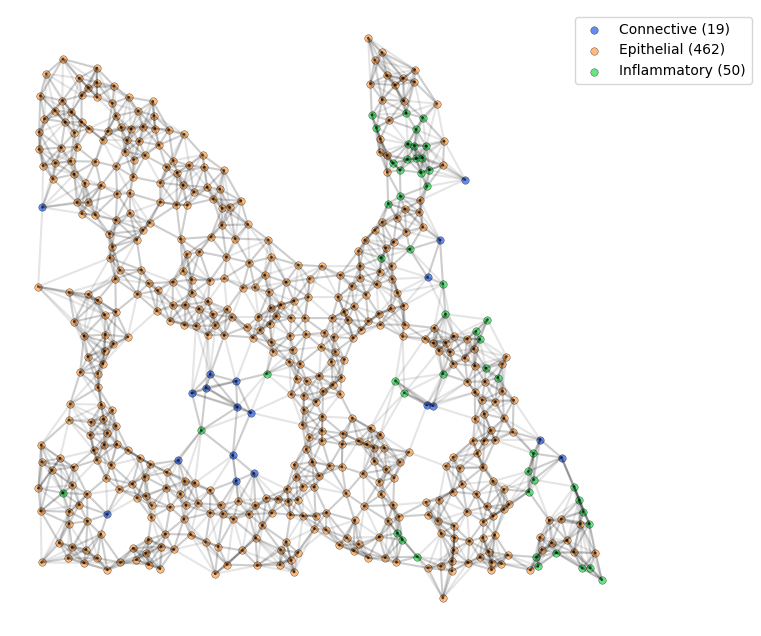

In [15]:
import matplotlib.pyplot as plt


# 使用matplotlib进行可视化
plt.figure(figsize=(8, 8))

color_dict = {
    "Connective": "#235cec",
    "Dead": "#feff00", 
    "Epithelial": "#ff9f44",
    "Inflammatory": "#22dd4d",
    "Neoplastic": "#ff0000",
}

# 使用pos绘制节点
# 为每种类型分别绘制
for cell_type, color in color_dict.items():
    # 找到当前类型的细胞索引
    mask = np.array([ct == cell_type for ct in cell_types])
    
    if np.any(mask):  # 如果存在该类型的细胞
        plt.scatter(pos[mask, 0], pos[mask, 1], 
                    c=color, 
                    label=f'{cell_type} ({np.sum(mask)})', 
                    alpha=0.7, 
                    s=29,
                    edgecolors='black',
                    linewidth=0.3)
#plt.scatter(pos[:, 0], pos[:, 1])
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left')
# 绘制边
for (i, j) in edge_index.T:
    plt.plot([pos[int(i),0], pos[int(j),0]], 
             [pos[int(i),1], pos[int(j),1]], 'k-', alpha=0.1)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [58]:
len(pos)

374